# Finetuning Llama 3 con LoRA

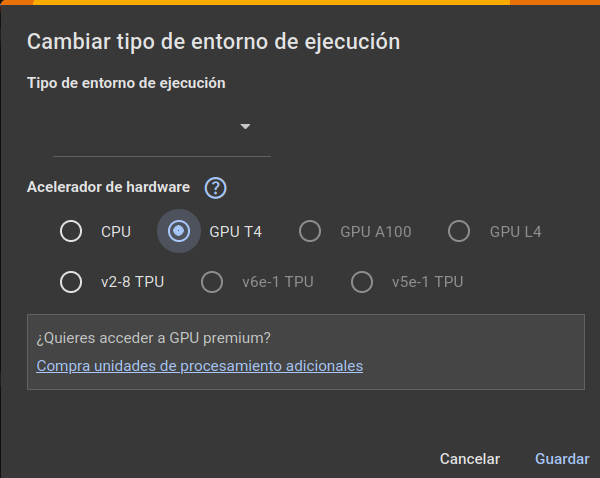

In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install --no-cache-dir torch==2.6.0+cu124 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 --index-url https://download.pytorch.org/whl/cu124


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 266.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 158.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 180.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 181.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56

In [ ]:
import torch
import transformers

print("torch:", torch.__version__)
print("transformers:", transformers.__version__)


torch: 2.6.0+cu124
transformers: 4.55.2


In [ ]:
import os
from huggingface_hub import login
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    TrainerCallback
)
from peft import LoraConfig, get_peft_model
import torch

In [ ]:

DATASET_NAME = "JulianVelandia/ColombianAccent"
MODEL_NAME   = "meta-llama/Llama-3.2-1B"
OUTPUT_DIR = "/content/drive/MyDrive/modelos-edteam/Llama-3.2-1B-acento-ft"
HUGGINGFACE_TOKEN = ":)"
LORA_RANK    = 32     # cuántos parámetros extra entrena LoRA
LORA_ALPHA   = 64     # qué tanto pesan esas actualizaciones
LORA_DROPOUT = 0.05   # chance de apagar conexiones para no sobreajustar

LEARNING_RATE         = 1e-4  # qué tan grandes son los pasos de aprendizaje
PER_DEVICE_BATCH_SIZE = 2     # cuántos ejemplos procesa a la vez por GPU/CPU
GRADIENT_ACCUMULATION = 4     # acumula pasos chicos para simular un batch grande
EPOCHS                = 3     # veces que recorre todo el dataset
SAVE_STEPS            = 250   # cada cuántos pasos guarda un checkpoint


login(token=HUGGINGFACE_TOKEN)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.makedirs(OUTPUT_DIR, exist_ok=True)

Mounted at /content/drive


In [ ]:
#Cargar dataset

dataset = load_dataset(DATASET_NAME, split="train")
print("Columnas:", dataset.column_names)
print(dataset[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/6.39M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30833 [00:00<?, ? examples/s]

Columnas: ['dataset', 'instruction', 'response']
{'dataset': 'Nicky0007/cointelegraph_noticias_Es', 'instruction': '¿Qué pasa, hermano, con el optimismo sobre Bitcoin después del abril loco en las criptomonedas?', 'response': 'Pues, parce, parece que el precio de Bitcoin está bajando y los inversores están un poco desanimados.'}


In [ ]:
# Cargar modelo y tokenizer
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto",
    use_auth_token=True
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_auth_token=True)
tokenizer.padding_side = "right"
tokenizer.chat_template = "{% for message in messages %}{% if loop.first %}{{ bos_token }}{% endif %}<|start_header_id|>{{ message['role'] }}<|end_header_id|>\n\n{{ message['content'] }}<|eot_id|>{% endfor %}{% if add_generation_prompt %}<|start_header_id|>assistant<|end_header_id|>\n\n{% endif %}"

#pad_token rellena los huecos y deja todas las secuencias del mismo tamaño
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/tokenization_auto.py:1001: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Embedding(128256, 2048)

In [ ]:
# LoRA
lora_config = LoraConfig(
    r=LORA_RANK,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 3,407,872 || all params: 1,239,222,272 || trainable%: 0.2750


In [ ]:
MAX_LEN = 1024

def preprocess_function(examples):
    msgs_prompt = [[{"role":"user","content":u}] for u in examples["instruction"]]
    msgs_full   = [[{"role":"user","content":u},{"role":"assistant","content":r}] for u,r in zip(examples["instruction"], examples["response"])]

    prompt_txt = [tokenizer.apply_chat_template(ms, tokenize=False, add_generation_prompt=True) for ms in msgs_prompt]
    full_txt   = [tokenizer.apply_chat_template(ms, tokenize=False, add_generation_prompt=False) for ms in msgs_full]

    tok_prompt = tokenizer(prompt_txt, add_special_tokens=False, truncation=True, max_length=MAX_LEN)
    tok_full   = tokenizer(full_txt, add_special_tokens=False, truncation=True, padding="max_length", max_length=MAX_LEN)

    input_ids = tok_full["input_ids"]
    pad_id = tokenizer.pad_token_id
    labels = []
    for ids, p_ids in zip(input_ids, tok_prompt["input_ids"]):
        n_prompt = len(p_ids)
        lab = ids.copy()
        for j in range(len(lab)):
            if j < n_prompt or lab[j] == pad_id:
                lab[j] = -100
        labels.append(lab)

    tok_full["labels"] = labels
    return tok_full


tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset.column_names)
print("Dataset tokenizado y listo")

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="no",# no evalúa durante el entrenamiento
    save_strategy="steps",
    save_steps=SAVE_STEPS,
    save_total_limit=2, # guarda solo los últimos 2 checkpoints
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=PER_DEVICE_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION, # junta pasos chicos para simular batch grande
    num_train_epochs=EPOCHS,
    logging_dir=f"{OUTPUT_DIR}/logs",
    fp16=True, # usa media precisión para ahorrar memoria y acelerar
    push_to_hub=False
)


Map:   0%|          | 0/30833 [00:00<?, ? examples/s]

Dataset tokenizado y listo


In [ ]:
# Checkpoints previos
import re

last_checkpoint = None
if os.path.exists(OUTPUT_DIR):
    checkpoints = [
        d for d in os.listdir(OUTPUT_DIR)
        if re.match(r"^checkpoint-\d+$", d)
    ]
    if checkpoints:
        last_checkpoint = os.path.join(
            OUTPUT_DIR,
            max(checkpoints, key=lambda x: int(x.split("-")[-1]))
        )

if last_checkpoint:
    print(f"Reanudando desde {last_checkpoint}")
else:
    print("Sin checkpoint previo")


class SaveCheckpointCallback(TrainerCallback):
    def on_save(self, args, state, control, **kwargs):
        print(f"Checkpoint guardado en paso {state.global_step}")

Reanudando desde /content/drive/MyDrive/modelos-edteam/Llama-3.2-1B-acento-ft/checkpoint-7500


In [ ]:
# Entrenamiento
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    callbacks=[SaveCheckpointCallback()]  # acción extra para avisar/gestionar cuando se guarda un checkpoint
)

print("Iniciando entrenamiento")
if last_checkpoint:
    trainer.train(resume_from_checkpoint=last_checkpoint)
else:
    trainer.train()

Iniciando entrenamiento


/tmp/ipython-input-116506290.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jvelandiag (julian-unal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
8000,1.853200
8500,1.829100
9000,1.841400
9500,1.834300
10000,1.839700
10500,1.838900
11000,1.834500
11500,1.860000


Checkpoint guardado en paso 7750
Checkpoint guardado en paso 8000
Checkpoint guardado en paso 8250
Checkpoint guardado en paso 8500
Checkpoint guardado en paso 8750
Checkpoint guardado en paso 9000
Checkpoint guardado en paso 9250
Checkpoint guardado en paso 9500
Checkpoint guardado en paso 9750
Checkpoint guardado en paso 10000
Checkpoint guardado en paso 10250
Checkpoint guardado en paso 10500
Checkpoint guardado en paso 10750
Checkpoint guardado en paso 11000
Checkpoint guardado en paso 11250
Checkpoint guardado en paso 11500


In [ ]:
!pip install -U --quiet "huggingface_hub>=0.33.6" cmake ninja mistral_common

import os, re, torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
from huggingface_hub import HfApi, login

ckpts = [d for d in os.listdir(OUTPUT_DIR) if re.match(r"^checkpoint-\d+$", d)]
assert ckpts, "No hay checkpoints en OUTPUT_DIR"
last_ckpt = os.path.join(OUTPUT_DIR, max(ckpts, key=lambda x: int(x.split("-")[-1])))

base_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="cpu", token=HUGGINGFACE_TOKEN)
lora_model = PeftModel.from_pretrained(base_model, last_ckpt)
full_model = lora_model.merge_and_unload()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, token=HUGGINGFACE_TOKEN)
tokenizer.chat_template = "{% for message in messages %}{% if loop.first %}{{ bos_token }}{% endif %}<|start_header_id|>{{ message['role'] }}<|end_header_id|>\n\n{{ message['content'] }}<|eot_id|>{% endfor %}<|start_header_id|>assistant<|end_header_id|>\n\n"

merged_dir = "/content/merged_llama"
os.makedirs(merged_dir, exist_ok=True)
full_model.save_pretrained(merged_dir)
tokenizer.save_pretrained(merged_dir)

!rm -rf llama.cpp
!git clone https://github.com/ggerganov/llama.cpp
!mkdir -p /content/gguf_model
!python3 llama.cpp/convert_hf_to_gguf.py /content/merged_llama --outfile /content/gguf_model/model-f16.gguf --outtype f16
!cmake -S llama.cpp -B llama.cpp/build
!cmake --build llama.cpp/build -j 2
!llama.cpp/build/bin/llama-quantize /content/gguf_model/model-f16.gguf /content/gguf_model/model-q4_k_m.gguf Q4_K_M
!ls -lh /content/gguf_model

login(token=HUGGINGFACE_TOKEN)
api = HfApi()
repo_id = "JulianVelandia/Llama-3.2-1B-acento-ft-gguf"
api.create_repo(repo_id, repo_type="model", exist_ok=True)
api.upload_folder(folder_path=merged_dir, repo_id=repo_id, repo_type="model")
api.upload_folder(folder_path="/content/gguf_model", repo_id=repo_id, repo_type="model")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.9 MB/s eta 0:00:00
Cloning into 'llama.cpp'...
remote: Enumerating objects: 60336, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 60336 (delta 158), reused 45 (delta 45), pack-reused 60096 (from 2)
Receiving objects: 100% (60336/60336), 150.60 MiB | 29.88 MiB/s, done.
Resolving deltas: 100% (43743/43743), done.
INFO:hf-to-gguf:Loading model: merged_llama
INFO:hf-to-gguf:Model architecture: LlamaForCausalLM
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F32, shape = {32}
INFO:hf-to-gguf:gguf: loading model pa

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...tent/merged_llama/model.safetensors:   1%|1         | 25.1MB / 2.47GB            

  /content/merged_llama/tokenizer.json  : 100%|##########| 17.2MB / 17.2MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /content/gguf_model/model-q4_k_m.gguf :   3%|3         | 25.0MB /  808MB            

  /content/gguf_model/model-f16.gguf    :   1%|1         | 25.0MB / 2.48GB            

CommitInfo(commit_url='https://huggingface.co/JulianVelandia/Llama-3.2-1B-acento-ft-gguf/commit/6f22e03fd5648f84c87287e7338f9e4a8a1c22d8', commit_message='Upload folder using huggingface_hub', commit_description='', oid='6f22e03fd5648f84c87287e7338f9e4a8a1c22d8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/JulianVelandia/Llama-3.2-1B-acento-ft-gguf', endpoint='https://huggingface.co', repo_type='model', repo_id='JulianVelandia/Llama-3.2-1B-acento-ft-gguf'), pr_revision=None, pr_num=None)